# Netflix titles and IMDb ratings - EDA

In this notebook I am going to merge a netflix titles dataset from https://www.kaggle.com/shivamb/netflix-shows/kernels with IMDb dataset
in order to get ratings values for the MOVIES available on netflix, and try to find some insights. 
My exploratory data analysis of the netflix titles dataset can be foud here - https://www.kaggle.com/mykytazharov/eda-of-a-netflix-dataset-with-plotly-in-r .

Note: the movies will be merged on title and the release year. Some films from the netflix dataset will not be found in the IMDb dataset. Further improvement of the merging can be implemented, as well as imputing the missing values.

Import modules

In [138]:
import pandas as pd
import csv
import numpy
import seaborn as sns
import matplotlib.pyplot as plt

Load IMDb data in .tsv format and save it into dataframes.
I am going to use two datasets from the https://www.imdb.com/interfaces/. 
Information courtesy of IMDb (http://www.imdb.com). Used with permission.
The two datasets are: 
* "title.basics.tsv.gz" - here I take a title of the movie and release year
* "title.ratings.tsv.gz" - here I take ratings for the titles

## Data reading and cleaning

In [139]:
#read data into a datagrame
title_ratings=pd.read_csv("title.ratings.tsv", sep='\t')

In [140]:
title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1600
1,tt0000002,6.0,196
2,tt0000003,6.5,1275
3,tt0000004,6.1,121
4,tt0000005,6.1,2037


In [141]:
#number of rows in the dataframe
title_ratings.shape

(1024336, 3)

In [142]:
#check if we have unique ratings for the titles
title_ratings.groupby(['tconst'], as_index=False).count()

,tconst,averageRating,numVotes
0,tt0000001,1,1
1,tt0000002,1,1
2,tt0000003,1,1
3,tt0000004,1,1
4,tt0000005,1,1
...,...,...,...
1024331,tt9916576,1,1
1024332,tt9916578,1,1
1024333,tt9916720,1,1
1024334,tt9916766,1,1


From the above output we see that we have unique rating values for each title.

In [143]:
title_basics=pd.read_csv("title.basics.tsv", sep='\t')
title_basics=title_basics.drop_duplicates()

In [144]:
title_basics=title_basics[['titleType','tconst','primaryTitle', 'originalTitle', 'startYear']]
title_basics=title_basics[title_basics.titleType=='movie']
title_basics=title_basics[title_basics.startYear.apply(lambda x: str(x).isnumeric())]
title_basics.head()

,titleType,tconst,primaryTitle,originalTitle,startYear
12,movie,tt0000009,Miss Jerry,Miss Jerry,1894
230,movie,tt0000147,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897
518,movie,tt0000335,Soldiers of the Cross,Soldiers of the Cross,1900
791,movie,tt0000502,Bohemios,Bohemios,1905
911,movie,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906


In [145]:
title_basics.shape

(484748, 5)

In [146]:
grouped=title_basics.groupby(['primaryTitle', 'startYear'], as_index=False).count()
grouped.head()

,primaryTitle,startYear,titleType,tconst,originalTitle
0,!Women Art Revolution,2010,1,1,1
1,#1 Serial Killer,2013,1,1,1
2,#19,2021,1,1,1
3,#1915House,2018,1,1,1
4,#5,2013,1,1,1


Now we join titles_basics and title_ratings dataframes on tconst (Index).

In [147]:
ratings_and_titles=pd.merge(title_ratings.set_index('tconst'), title_basics.set_index('tconst'), left_index=True, right_index=True, how='inner')
ratings_and_titles=ratings_and_titles.drop_duplicates()

In [148]:
ratings_and_titles.head()

,averageRating,numVotes,titleType,primaryTitle,originalTitle,startYear
tconst,,,,,,
tt0000009,5.3,89,movie,Miss Jerry,Miss Jerry,1894
tt0000147,5.2,338,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,1897
tt0000335,6.1,40,movie,Soldiers of the Cross,Soldiers of the Cross,1900
tt0000502,4.4,5,movie,Bohemios,Bohemios,1905
tt0000574,6.1,565,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,1906


In [149]:
ratings_and_titles.shape

(246683, 6)

Now we load netflix titles dataset and join it with ratings_and_titles dataframe on title and primaryTitle.

In [150]:
netflix_titles=pd.read_csv("netflix_titles.csv", index_col="show_id")

We drop rows where we dont have release_year.

In [151]:
netflix_titles=netflix_titles.dropna(subset=['release_year'])

We need to change to integer the release_year column first.

In [152]:
netflix_titles.release_year=netflix_titles.release_year.astype(numpy.int64)

Drop rows in ratings_and_titles with non-numeric values for startYear and convert to integer.

In [153]:
ratings_and_titles=ratings_and_titles[ratings_and_titles.startYear.apply(lambda x: str(x).isnumeric())]

In [154]:
ratings_and_titles.startYear=ratings_and_titles.startYear.astype(numpy.int64)

Convert titles to lowercase.

In [155]:
netflix_titles['title']=netflix_titles['title'].str.lower()
ratings_and_titles['originalTitle']=ratings_and_titles['originalTitle'].str.lower()
ratings_and_titles['primaryTitle']=ratings_and_titles['primaryTitle'].str.lower()

Now we can join netflix titles with IMDb ratings on title name and release year.

In [156]:
##subset movies
netflix_titles=netflix_titles[netflix_titles.type=='Movie']

In [157]:
netflix_titles.shape

(4265, 11)

In [158]:
netflix_titles_rating=pd.merge(netflix_titles, ratings_and_titles, left_on=['title', 'release_year'], right_on=['primaryTitle', 'startYear'], how='inner')

## Exploratory data analysis

Sort the obtained data frame by averageRating and number of votes.

In [159]:
netflix_titles_rating.sort_values(by=['averageRating', 'numVotes'], inplace=True, ascending=False)

In [160]:
#look at titles where we have more than 2000 votes
netflix_titles_rating_2000=netflix_titles_rating[netflix_titles_rating.numVotes>2000]

In [161]:
netflix_titles_rating_2000.head(10)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,averageRating,numVotes,titleType,primaryTitle,originalTitle,startYear
1918,Movie,pulp fiction,Quentin Tarantino,"John Travolta, Samuel L. Jackson, Uma Thurman,...",United States,"January 1, 2019",1994,R,154 min,"Classic Movies, Cult Movies, Dramas",This stylized crime caper weaves together stor...,8.9,1738354,movie,pulp fiction,pulp fiction,1994
1879,Movie,the lord of the rings: the return of the king,Peter Jackson,"Elijah Wood, Ian McKellen, Liv Tyler, Viggo Mo...","New Zealand, United States","January 1, 2020",2003,PG-13,201 min,"Action & Adventure, Sci-Fi & Fantasy",Aragorn is revealed as the heir to the ancient...,8.9,1571125,movie,the lord of the rings: the return of the king,the lord of the rings: the return of the king,2003
2877,Movie,schindler's list,Steven Spielberg,"Liam Neeson, Ben Kingsley, Ralph Fiennes, Caro...",United States,"April 1, 2018",1993,R,195 min,"Classic Movies, Dramas",Oskar Schindler becomes an unlikely humanitari...,8.9,1154264,movie,schindler's list,schindler's list,1993
1837,Movie,inception,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...","United States, United Kingdom","January 1, 2020",2010,PG-13,148 min,"Action & Adventure, Sci-Fi & Fantasy, Thrillers","In this mind-bending sci-fi thriller, a man ru...",8.8,1941631,movie,inception,inception,2010
748,Movie,the matrix,"Lilly Wachowski, Lana Wachowski","Keanu Reeves, Laurence Fishburne, Carrie-Anne ...",United States,"November 1, 2019",1999,R,136 min,"Action & Adventure, Sci-Fi & Fantasy",A computer hacker learns that what most people...,8.7,1592527,movie,the matrix,the matrix,1999
1880,Movie,the lord of the rings: the two towers,Peter Jackson,"Elijah Wood, Ian McKellen, Liv Tyler, Viggo Mo...","New Zealand, United States","January 1, 2020",2002,PG-13,179 min,"Action & Adventure, Sci-Fi & Fantasy",Frodo and Sam head to Mordor to destroy the On...,8.7,1418801,movie,the lord of the rings: the two towers,the lord of the rings: the two towers,2002
1996,Movie,be here now,Lilibet Foster,Andy Whitfield,"United States, Australia","February 28, 2017",2015,TV-MA,110 min,Documentaries,Trace the brave journey of actor Andy Whitfiel...,8.7,3065,movie,be here now,be here now,2015
1816,Movie,city of god,"Fernando Meirelles, Katia Lund","Alexandre Rodrigues, Leandro Firmino, Phellipe...","Brazil, France, Germany","January 1, 2020",2002,R,130 min,"Dramas, Independent Movies, International Movies","Growing up in a Rio de Janeiro slum, Rocket is...",8.6,672399,movie,city of god,cidade de deus,2002
2210,Movie,gol maal,Hrishikesh Mukherjee,"Amol Palekar, Bindiya Goswami, Deven Verma, Ut...",India,"December 31, 2019",1979,TV-PG,137 min,"Classic Movies, Comedies, International Movies",When circumstances at work compel Ram to prete...,8.6,16556,movie,gol maal,gol maal,1979
2434,Movie,the departed,Martin Scorsese,"Leonardo DiCaprio, Matt Damon, Jack Nicholson,...",United States,"December 1, 2019",2006,R,151 min,"Dramas, Thrillers",Two rookie Boston cops are sent deep undercove...,8.5,1131368,movie,the departed,the departed,2006


### What is the distribution of the average ratings?

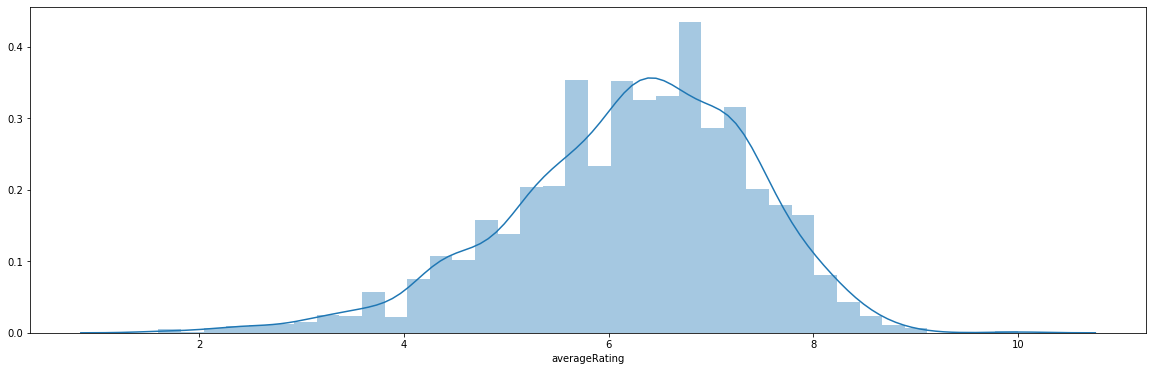

In [162]:
plt.figure(figsize=(20, 6))
sns.distplot(netflix_titles_rating['averageRating']);

The output above shows something similar to the normal distribution.

### What is the distribution of number of votes?

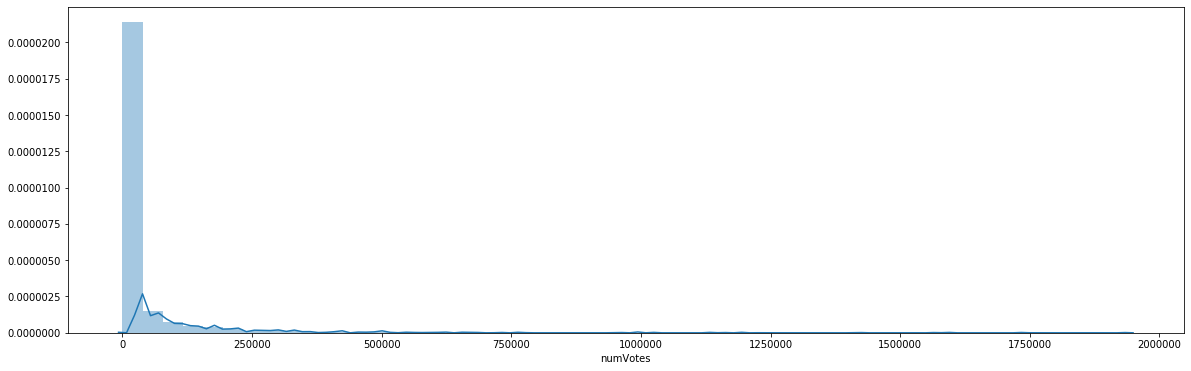

In [163]:
plt.figure(figsize=(20, 6))
sns.distplot(netflix_titles_rating['numVotes']);

### What are the top ten movies on netflix according to the IMDb rating?

In [164]:
netflix_titles_rating_2000.head(10)['title']

1918                                     pulp fiction
1879    the lord of the rings: the return of the king
2877                                 schindler's list
1837                                        inception
748                                        the matrix
1880            the lord of the rings: the two towers
1996                                      be here now
1816                                      city of god
2210                                         gol maal
2434                                     the departed
Name: title, dtype: object

### What are the countries producing the 100 most populat films?

In [165]:
top_countries=netflix_titles_rating_2000.head(100)['country'].value_counts()

In [166]:
top_countries

United States                                                                                               34
India                                                                                                       31
United Kingdom                                                                                               5
New Zealand, United States                                                                                   2
Spain                                                                                                        2
United States, United Kingdom                                                                                2
United States, Japan                                                                                         1
Canada                                                                                                       1
Italy, United States                                                                                         1
A

### What are the top genres of the 100 most popular films?

Since movies may be listed in many genres, we need firstly to split them.

In [167]:
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = netflix_titles_rating_2000.head(100)['listed_in'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
res = pd.DataFrame({'title': numpy.repeat(netflix_titles_rating_2000.head(100)['title'], lens),
                    'listed_in': chainer(netflix_titles_rating_2000.head(100)['listed_in']),
                    })
res['listed_in']=res['listed_in'].str.strip()

print(res)

                                              title                 listed_in
1918                                   pulp fiction            Classic Movies
1918                                   pulp fiction               Cult Movies
1918                                   pulp fiction                    Dramas
1879  the lord of the rings: the return of the king        Action & Adventure
1879  the lord of the rings: the return of the king          Sci-Fi & Fantasy
...                                             ...                       ...
1596                                     i am kalam  Children & Family Movies
1596                                     i am kalam                  Comedies
1596                                     i am kalam                    Dramas
1560              the battered bastards of baseball             Documentaries
1560              the battered bastards of baseball             Sports Movies

[235 rows x 2 columns]


In [168]:
top_genres=res['listed_in'].value_counts()

In [169]:
top_genres

Dramas                      58
International Movies        45
Documentaries               20
Action & Adventure          20
Comedies                    20
Classic Movies              17
Thrillers                   12
Independent Movies          10
Sci-Fi & Fantasy             8
Sports Movies                6
Romantic Movies              6
Cult Movies                  4
Children & Family Movies     3
Music & Musicals             3
Stand-Up Comedy              1
Horror Movies                1
LGBTQ Movies                 1
Name: listed_in, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

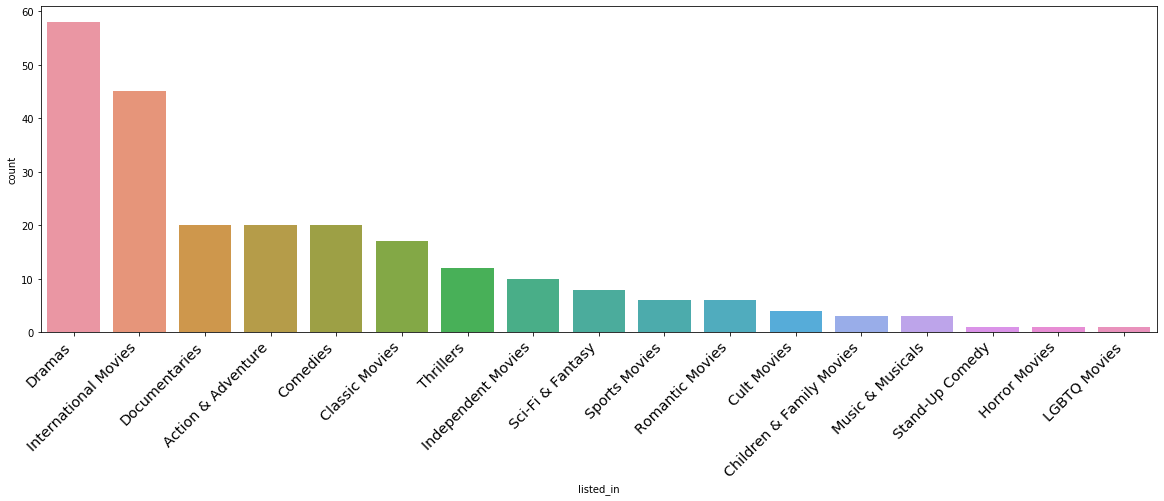

In [170]:
plt.figure(figsize=(20, 6))
chart=sns.countplot(x="listed_in", data=res, order = res['listed_in'].value_counts().index)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

In [171]:
#save plot
chart.figure.savefig("pop_genres.png")

In [93]:
#save to the file
#netflix_titles_rating.to_csv('netflix_titles_rating_movies.csv')